In [618]:
'Test_Task1 seat or carrier seat Classification using XG Boost model and MLP model'

'Test_Task1 seat or carrier seat Classification using XG Boost model and MLP model'

In [619]:
import gc
gc.collect()

4823

In [620]:
%reset -f

In [621]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

# Test measurements

In [622]:
import os
import numpy as np
import pandas as pd

# Define path (2 levels up -> Data/Processed)
file_path = os.path.join("..", "..", "Data", "Test", "test_Emptyseat_npy_array_Lowpassfiltered_label.npy")

# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Convert to DataFrame
dataframe_testdata = pd.DataFrame(
    loaded_array,
    columns=['Frequency', 'FFT Magnitude', 'Phase', 'Object_Presence']
)

# Take first 2000 rows (or use sampling instead if needed)
dataframe_testdata = dataframe_testdata.iloc[:2000]
# dataframe_testdata = dataframe_testdata.sample(n=2000, random_state=42)

print(f"Data loaded from: {os.path.abspath(file_path)}")
dataframe_testdata


Data loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Data/Test/test_Emptyseat_npy_array_Lowpassfiltered_label.npy


,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.00000,17591.160470,0.000000,0.0
1,488.28125,8624.422770,-3.116442,0.0
2,976.56250,269.932200,2.781762,0.0
3,1464.84375,101.451438,1.259705,0.0
4,1953.12500,159.854316,-0.154286,0.0
...,...,...,...,...
1995,974121.09375,382.129825,0.512916,0.0
1996,974609.37500,385.904814,-2.873235,0.0
1997,975097.65625,363.592039,-0.043251,0.0
1998,975585.93750,330.245526,-2.947535,0.0


In [623]:
num_rows_test = len(dataframe_testdata)
num_rows_test

2000

In [624]:
fft_magnitudes_test = dataframe_testdata["FFT Magnitude"].values  # Convert to NumPy array
fft_magnitudes_test

array([17591.16046978,  8624.42277002,   269.93219957, ...,
         363.59203886,   330.24552634,   178.40396818], shape=(2000,))

In [625]:
fft_frequencies_test = dataframe_testdata["Frequency"].values  # Convert to NumPy array
fft_frequencies_test

array([0.00000000e+00, 4.88281250e+02, 9.76562500e+02, ...,
       9.75097656e+05, 9.75585937e+05, 9.76074219e+05], shape=(2000,))

In [626]:
fft_phase_test = dataframe_testdata["Phase"].values  # Convert to NumPy array
fft_phase_test

array([ 0.        , -3.11644234,  2.78176198, ..., -0.04325127,
       -2.94753519,  1.89234963], shape=(2000,))

In [627]:
import numpy as np
from scipy.stats import entropy
from scipy.signal import find_peaks

def extract_features(fft_freqs, fft_mags, fft_phase):
    # Normalize magnitudes to prevent division errors
    norm_mags = fft_mags / np.sum(fft_mags) if np.sum(fft_mags) > 0 else fft_mags
    
    # Spectral Centroid (Weighted Mean of Frequencies)
    spectral_centroid = np.sum(fft_freqs * norm_mags) / np.sum(norm_mags)

    # Spectral Bandwidth (Spread around centroid)
    spectral_bandwidth = np.sqrt(np.sum(norm_mags * (fft_freqs - spectral_centroid) ** 2))

    # Spectral Flatness (Geometric Mean / Arithmetic Mean)
    spectral_flatness = np.exp(np.mean(np.log(fft_mags + 1e-10))) / np.mean(fft_mags + 1e-10)

    # Phase Features
    phase_variance = np.var(fft_phase)  # Variance of phase angles
    phase_mean = np.mean(fft_phase)  # Mean of phase angles
    phase_diff = np.mean(np.diff(fft_phase))  # Average phase difference between frequencies

    return {
        "mean_fft": np.mean(fft_mags),
        "std_fft": np.std(fft_mags),
        "max_fft": np.max(fft_mags),
        "min_fft": np.min(fft_mags),
        "median_fft": np.median(fft_mags),
        "sum_fft": np.sum(fft_mags),
        "spectral_entropy": entropy(norm_mags),  # Energy spread
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "phase_variance": phase_variance,
        "phase_mean": phase_mean,
        "phase_diff": phase_diff,
    }


In [628]:
# Function to apply perturbation based on reference values
def add_perturbation(reference_features, num_rows, perturb_range=0.03):
    perturbed_data = []
    
    for _ in range(num_rows):
        perturbed_features = {
            key: value * (1 + np.random.uniform(-perturb_range, perturb_range)) 
            for key, value in reference_features.items()
        }
        perturbed_data.append(perturbed_features)
    
    return pd.DataFrame(perturbed_data)

In [629]:
# Extract features for fft_test
reference_features_test = extract_features(fft_frequencies_test, fft_magnitudes_test, fft_phase_test)
reference_features_test

{'mean_fft': np.float64(315.68738982606305),
 'std_fft': np.float64(463.08835097174983),
 'max_fft': np.float64(17591.160469784256),
 'min_fft': np.float64(7.302704927261968),
 'median_fft': np.float64(275.6937819378809),
 'sum_fft': np.float64(631374.7796521261),
 'spectral_entropy': np.float64(7.326219826670075),
 'spectral_centroid': np.float64(495862.10231327085),
 'spectral_bandwidth': np.float64(300149.40921247046),
 'phase_variance': np.float64(3.296296235765856),
 'phase_mean': np.float64(-0.08472123499579763),
 'phase_diff': np.float64(0.0009466481397022505)}

In [630]:
# Generate a DataFrame with perturbed values for all rows in fft_test
num_rows_test = len(dataframe_testdata)
perturbed_test_df = add_perturbation(reference_features_test, num_rows_test, perturb_range=0.03)
perturbed_test_df

,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,318.600181,468.558621,17224.978456,7.269434,282.198676,643377.404367,7.316601,486701.170193,291489.209983,3.275463,-0.082196,0.000958
1,315.215893,456.412580,18042.490288,7.388295,280.656329,630127.934386,7.422958,483712.225649,296312.576082,3.291654,-0.082632,0.000956
2,316.461154,470.865288,17180.777687,7.480188,270.387726,616360.957090,7.120073,502923.632115,299904.579739,3.296420,-0.083456,0.000934
3,313.561370,455.786536,17657.641399,7.499865,275.088178,640792.036281,7.455544,506073.243608,301620.727450,3.388060,-0.086060,0.000922
4,312.454568,462.831566,17680.628582,7.414812,273.704995,650001.723700,7.405890,502242.840790,300311.043421,3.338405,-0.085781,0.000953
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,316.337325,468.897888,17147.656950,7.333275,278.851641,626837.868077,7.160212,488807.518948,308643.439510,3.275060,-0.086539,0.000967
1996,315.592439,451.360132,17668.622378,7.511690,270.840720,629133.318250,7.458356,508619.427139,305236.378325,3.242180,-0.084794,0.000944
1997,322.501956,452.150021,17221.183777,7.185765,283.881155,646490.893748,7.260432,503932.833879,291339.541187,3.351336,-0.084059,0.000973
1998,322.383220,455.706535,17340.759941,7.274671,279.777435,635049.889772,7.386870,510333.092034,302796.492133,3.331355,-0.083042,0.000925


In [631]:
dataframe_testdata

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.00000,17591.160470,0.000000,0.0
1,488.28125,8624.422770,-3.116442,0.0
2,976.56250,269.932200,2.781762,0.0
3,1464.84375,101.451438,1.259705,0.0
4,1953.12500,159.854316,-0.154286,0.0
...,...,...,...,...
1995,974121.09375,382.129825,0.512916,0.0
1996,974609.37500,385.904814,-2.873235,0.0
1997,975097.65625,363.592039,-0.043251,0.0
1998,975585.93750,330.245526,-2.947535,0.0


In [632]:
len(perturbed_test_df),len(dataframe_testdata)

(2000, 2000)

In [633]:
# Ensure both DataFrames have the same number of rows
if len(dataframe_testdata) != len(perturbed_test_df):
    print("The DataFrames have different lengths. Adjust them to have the same number of rows before concatenating.")
else:
    # Concatenate the DataFrames side by side
    dataframe_testdata_withfeatures = pd.concat([dataframe_testdata, perturbed_test_df], axis=1)

# Display the first few rows of the updated dataframe_testdata to verify
dataframe_testdata_withfeatures.head()

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.00000,17591.160470,0.000000,0.0,318.600181,468.558621,17224.978456,7.269434,282.198676,643377.404367,7.316601,486701.170193,291489.209983,3.275463,-0.082196,0.000958
1,488.28125,8624.422770,-3.116442,0.0,315.215893,456.412580,18042.490288,7.388295,280.656329,630127.934386,7.422958,483712.225649,296312.576082,3.291654,-0.082632,0.000956
2,976.56250,269.932200,2.781762,0.0,316.461154,470.865288,17180.777687,7.480188,270.387726,616360.957090,7.120073,502923.632115,299904.579739,3.296420,-0.083456,0.000934
3,1464.84375,101.451438,1.259705,0.0,313.561370,455.786536,17657.641399,7.499865,275.088178,640792.036281,7.455544,506073.243608,301620.727450,3.388060,-0.086060,0.000922
4,1953.12500,159.854316,-0.154286,0.0,312.454568,462.831566,17680.628582,7.414812,273.704995,650001.723700,7.405890,502242.840790,300311.043421,3.338405,-0.085781,0.000953


In [634]:
len(dataframe_testdata_withfeatures)

2000

In [635]:
dataframe_testdata_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.00000,17591.160470,0.000000,0.0,318.600181,468.558621,17224.978456,7.269434,282.198676,643377.404367,7.316601,486701.170193,291489.209983,3.275463,-0.082196,0.000958
1,488.28125,8624.422770,-3.116442,0.0,315.215893,456.412580,18042.490288,7.388295,280.656329,630127.934386,7.422958,483712.225649,296312.576082,3.291654,-0.082632,0.000956
2,976.56250,269.932200,2.781762,0.0,316.461154,470.865288,17180.777687,7.480188,270.387726,616360.957090,7.120073,502923.632115,299904.579739,3.296420,-0.083456,0.000934
3,1464.84375,101.451438,1.259705,0.0,313.561370,455.786536,17657.641399,7.499865,275.088178,640792.036281,7.455544,506073.243608,301620.727450,3.388060,-0.086060,0.000922
4,1953.12500,159.854316,-0.154286,0.0,312.454568,462.831566,17680.628582,7.414812,273.704995,650001.723700,7.405890,502242.840790,300311.043421,3.338405,-0.085781,0.000953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,974121.09375,382.129825,0.512916,0.0,316.337325,468.897888,17147.656950,7.333275,278.851641,626837.868077,7.160212,488807.518948,308643.439510,3.275060,-0.086539,0.000967
1996,974609.37500,385.904814,-2.873235,0.0,315.592439,451.360132,17668.622378,7.511690,270.840720,629133.318250,7.458356,508619.427139,305236.378325,3.242180,-0.084794,0.000944
1997,975097.65625,363.592039,-0.043251,0.0,322.501956,452.150021,17221.183777,7.185765,283.881155,646490.893748,7.260432,503932.833879,291339.541187,3.351336,-0.084059,0.000973
1998,975585.93750,330.245526,-2.947535,0.0,322.383220,455.706535,17340.759941,7.274671,279.777435,635049.889772,7.386870,510333.092034,302796.492133,3.331355,-0.083042,0.000925


In [636]:
# You can directly test whether the model is predicting this set of data as true or not by running it through loaded model 
# You can skip the second half of the dateset and start from the dropping features section

# Carrierseat data 

In [637]:
import os
import numpy as np
import pandas as pd

# Define the dataset file name
filename = "test_Carrierseat_withoutbaby_npy_array_Lowpassfiltered_withlabel_1.npy"

# Build full path (2 levels up -> Data/Processed/)
file_path = os.path.join("..", "..", "Data", "Test", filename)

# Load the NumPy array
loaded_array = np.load(file_path, mmap_mode='r')

# Convert to DataFrame
dataframe_carrierseat = pd.DataFrame( loaded_array, columns=['Frequency', 'FFT Magnitude', 'Phase', 'Object_Presence'])

print(f"Data loaded from: {os.path.abspath(file_path)}")
dataframe_carrierseat


Data loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Data/Test/test_Carrierseat_withoutbaby_npy_array_Lowpassfiltered_withlabel_1.npy


,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.00000,16732.464039,0.000000,1.0
1,488.28125,8333.605309,3.112956,1.0
2,976.56250,204.398557,-1.629384,1.0
3,1464.84375,124.749508,1.244306,1.0
4,1953.12500,218.879548,-2.558848,1.0
...,...,...,...,...
3995,-2441.40625,112.613316,-0.375541,1.0
3996,-1953.12500,218.879548,2.558848,1.0
3997,-1464.84375,124.749508,-1.244306,1.0
3998,-976.56250,204.398557,1.629384,1.0


In [638]:
fft_magnitudes_carrier = dataframe_carrierseat["FFT Magnitude"].values  # Convert to NumPy array
fft_frequencies_carrier = dataframe_carrierseat["Frequency"].values  # Convert to NumPy array
fft_phase_carrier = dataframe_carrierseat["Phase"].values  # Convert to NumPy array


In [639]:
# Extract features for fft_carrier
reference_features_carrier = extract_features(fft_frequencies_carrier, fft_magnitudes_carrier, fft_phase_carrier)
reference_features_carrier

{'mean_fft': np.float64(325.95225423295017),
 'std_fft': np.float64(378.9192634886786),
 'max_fft': np.float64(16732.464038774917),
 'min_fft': np.float64(8.289574826003792),
 'median_fft': np.float64(275.93543287593525),
 'sum_fft': np.float64(1303809.0169318006),
 'spectral_entropy': np.float64(8.0351420470818),
 'spectral_centroid': np.float64(-70.97002611338394),
 'spectral_bandwidth': np.float64(579371.9519415188),
 'phase_variance': np.float64(3.2899656084123654),
 'phase_mean': np.float64(5.3290705182007515e-18),
 'phase_diff': np.float64(-0.0007784337064980223)}

In [640]:
# Generate a DataFrame with perturbed values for all rows in fft_empty
num_rows_carrier = len(dataframe_carrierseat)
perturbed_carrier_df = add_perturbation(reference_features_carrier, num_rows_carrier, perturb_range=0.03)
perturbed_carrier_df

,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,318.330285,389.093660,16318.855664,8.052929,281.633461,1.314623e+06,7.825030,-71.945962,581857.524620,3.271427,5.247391e-18,-0.000776
1,327.040706,383.278733,17202.773927,8.043741,284.028801,1.293208e+06,8.137473,-70.666643,585642.987352,3.198409,5.317425e-18,-0.000794
2,327.161286,368.530189,16411.841295,8.354603,278.627602,1.320801e+06,7.898124,-70.290080,571911.546637,3.325029,5.169223e-18,-0.000788
3,319.461821,378.575702,17168.280566,8.512978,271.246332,1.270477e+06,7.953731,-69.564301,591041.230595,3.384166,5.250974e-18,-0.000791
4,327.601418,377.981627,16915.256799,8.463384,282.274885,1.330309e+06,8.255250,-72.840065,579455.660987,3.237448,5.321279e-18,-0.000792
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,329.765556,374.971096,16829.144792,8.116348,279.763016,1.293515e+06,8.113537,-70.459362,577967.466047,3.195398,5.452835e-18,-0.000774
3996,316.842214,374.023617,16731.441934,8.115313,282.911488,1.307164e+06,8.016343,-70.613398,563576.460672,3.216580,5.385061e-18,-0.000794
3997,317.973561,387.343038,17186.132879,8.101554,281.833872,1.329639e+06,8.178403,-70.361546,572671.883103,3.225008,5.393687e-18,-0.000771
3998,330.687414,381.565956,16523.659065,8.062200,277.047280,1.306455e+06,7.875151,-71.948329,567383.785723,3.355641,5.239821e-18,-0.000772


In [641]:
dataframe_carrierseat

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.00000,16732.464039,0.000000,1.0
1,488.28125,8333.605309,3.112956,1.0
2,976.56250,204.398557,-1.629384,1.0
3,1464.84375,124.749508,1.244306,1.0
4,1953.12500,218.879548,-2.558848,1.0
...,...,...,...,...
3995,-2441.40625,112.613316,-0.375541,1.0
3996,-1953.12500,218.879548,2.558848,1.0
3997,-1464.84375,124.749508,-1.244306,1.0
3998,-976.56250,204.398557,1.629384,1.0


In [642]:
len(perturbed_carrier_df),len(dataframe_carrierseat)

(4000, 4000)

In [643]:

# Ensure both DataFrames have the same number of rows
if len(dataframe_carrierseat) != len(perturbed_carrier_df):
    print("The DataFrames have different lengths. Adjust them to have the same number of rows before concatenating.")
else:
    # Concatenate the DataFrames side by side
    dataframe_carrierseat_withfeatures = pd.concat([dataframe_carrierseat, perturbed_carrier_df], axis=1)

# Display the first few rows of the updated dataframe_emptyseat to verify
dataframe_carrierseat_withfeatures.head()

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.00000,16732.464039,0.000000,1.0,318.330285,389.093660,16318.855664,8.052929,281.633461,1.314623e+06,7.825030,-71.945962,581857.524620,3.271427,5.247391e-18,-0.000776
1,488.28125,8333.605309,3.112956,1.0,327.040706,383.278733,17202.773927,8.043741,284.028801,1.293208e+06,8.137473,-70.666643,585642.987352,3.198409,5.317425e-18,-0.000794
2,976.56250,204.398557,-1.629384,1.0,327.161286,368.530189,16411.841295,8.354603,278.627602,1.320801e+06,7.898124,-70.290080,571911.546637,3.325029,5.169223e-18,-0.000788
3,1464.84375,124.749508,1.244306,1.0,319.461821,378.575702,17168.280566,8.512978,271.246332,1.270477e+06,7.953731,-69.564301,591041.230595,3.384166,5.250974e-18,-0.000791
4,1953.12500,218.879548,-2.558848,1.0,327.601418,377.981627,16915.256799,8.463384,282.274885,1.330309e+06,8.255250,-72.840065,579455.660987,3.237448,5.321279e-18,-0.000792


In [644]:
# Vertical concatenation
dataset_1_rawdata = pd.concat([dataframe_testdata,dataframe_carrierseat])
dataset_1_rawdata

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.00000,17591.160470,0.000000,0.0
1,488.28125,8624.422770,-3.116442,0.0
2,976.56250,269.932200,2.781762,0.0
3,1464.84375,101.451438,1.259705,0.0
4,1953.12500,159.854316,-0.154286,0.0
...,...,...,...,...
3995,-2441.40625,112.613316,-0.375541,1.0
3996,-1953.12500,218.879548,2.558848,1.0
3997,-1464.84375,124.749508,-1.244306,1.0
3998,-976.56250,204.398557,1.629384,1.0


In [645]:
# Resetting the index if unique indices are needed
dataset_1_rawdata = dataset_1_rawdata.reset_index(drop=True)
dataset_1_rawdata

,Frequency,FFT Magnitude,Phase,Object_Presence
0,0.00000,17591.160470,0.000000,0.0
1,488.28125,8624.422770,-3.116442,0.0
2,976.56250,269.932200,2.781762,0.0
3,1464.84375,101.451438,1.259705,0.0
4,1953.12500,159.854316,-0.154286,0.0
...,...,...,...,...
5995,-2441.40625,112.613316,-0.375541,1.0
5996,-1953.12500,218.879548,2.558848,1.0
5997,-1464.84375,124.749508,-1.244306,1.0
5998,-976.56250,204.398557,1.629384,1.0


In [646]:
dataset_1_withfeatures = pd.concat([dataframe_testdata_withfeatures,dataframe_carrierseat_withfeatures])
dataset_1_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.00000,17591.160470,0.000000,0.0,318.600181,468.558621,17224.978456,7.269434,282.198676,6.433774e+05,7.316601,486701.170193,291489.209983,3.275463,-8.219626e-02,0.000958
1,488.28125,8624.422770,-3.116442,0.0,315.215893,456.412580,18042.490288,7.388295,280.656329,6.301279e+05,7.422958,483712.225649,296312.576082,3.291654,-8.263154e-02,0.000956
2,976.56250,269.932200,2.781762,0.0,316.461154,470.865288,17180.777687,7.480188,270.387726,6.163610e+05,7.120073,502923.632115,299904.579739,3.296420,-8.345586e-02,0.000934
3,1464.84375,101.451438,1.259705,0.0,313.561370,455.786536,17657.641399,7.499865,275.088178,6.407920e+05,7.455544,506073.243608,301620.727450,3.388060,-8.606002e-02,0.000922
4,1953.12500,159.854316,-0.154286,0.0,312.454568,462.831566,17680.628582,7.414812,273.704995,6.500017e+05,7.405890,502242.840790,300311.043421,3.338405,-8.578141e-02,0.000953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-2441.40625,112.613316,-0.375541,1.0,329.765556,374.971096,16829.144792,8.116348,279.763016,1.293515e+06,8.113537,-70.459362,577967.466047,3.195398,5.452835e-18,-0.000774
3996,-1953.12500,218.879548,2.558848,1.0,316.842214,374.023617,16731.441934,8.115313,282.911488,1.307164e+06,8.016343,-70.613398,563576.460672,3.216580,5.385061e-18,-0.000794
3997,-1464.84375,124.749508,-1.244306,1.0,317.973561,387.343038,17186.132879,8.101554,281.833872,1.329639e+06,8.178403,-70.361546,572671.883103,3.225008,5.393687e-18,-0.000771
3998,-976.56250,204.398557,1.629384,1.0,330.687414,381.565956,16523.659065,8.062200,277.047280,1.306455e+06,7.875151,-71.948329,567383.785723,3.355641,5.239821e-18,-0.000772


In [647]:
dataset_1_withfeatures = dataset_1_withfeatures.reset_index(drop=True)

In [648]:
dataframe_testdata_withfeatures = dataset_1_withfeatures

In [649]:
dataframe_testdata_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.00000,17591.160470,0.000000,0.0,318.600181,468.558621,17224.978456,7.269434,282.198676,6.433774e+05,7.316601,486701.170193,291489.209983,3.275463,-8.219626e-02,0.000958
1,488.28125,8624.422770,-3.116442,0.0,315.215893,456.412580,18042.490288,7.388295,280.656329,6.301279e+05,7.422958,483712.225649,296312.576082,3.291654,-8.263154e-02,0.000956
2,976.56250,269.932200,2.781762,0.0,316.461154,470.865288,17180.777687,7.480188,270.387726,6.163610e+05,7.120073,502923.632115,299904.579739,3.296420,-8.345586e-02,0.000934
3,1464.84375,101.451438,1.259705,0.0,313.561370,455.786536,17657.641399,7.499865,275.088178,6.407920e+05,7.455544,506073.243608,301620.727450,3.388060,-8.606002e-02,0.000922
4,1953.12500,159.854316,-0.154286,0.0,312.454568,462.831566,17680.628582,7.414812,273.704995,6.500017e+05,7.405890,502242.840790,300311.043421,3.338405,-8.578141e-02,0.000953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-2441.40625,112.613316,-0.375541,1.0,329.765556,374.971096,16829.144792,8.116348,279.763016,1.293515e+06,8.113537,-70.459362,577967.466047,3.195398,5.452835e-18,-0.000774
5996,-1953.12500,218.879548,2.558848,1.0,316.842214,374.023617,16731.441934,8.115313,282.911488,1.307164e+06,8.016343,-70.613398,563576.460672,3.216580,5.385061e-18,-0.000794
5997,-1464.84375,124.749508,-1.244306,1.0,317.973561,387.343038,17186.132879,8.101554,281.833872,1.329639e+06,8.178403,-70.361546,572671.883103,3.225008,5.393687e-18,-0.000771
5998,-976.56250,204.398557,1.629384,1.0,330.687414,381.565956,16523.659065,8.062200,277.047280,1.306455e+06,7.875151,-71.948329,567383.785723,3.355641,5.239821e-18,-0.000772


# dropping features

In [650]:
# Resetting the index if unique indices are needed
dataframe_testdata_withfeatures = dataframe_testdata_withfeatures.reset_index(drop=True)
dataframe_testdata_withfeatures

,Frequency,FFT Magnitude,Phase,Object_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,phase_variance,phase_mean,phase_diff
0,0.00000,17591.160470,0.000000,0.0,318.600181,468.558621,17224.978456,7.269434,282.198676,6.433774e+05,7.316601,486701.170193,291489.209983,3.275463,-8.219626e-02,0.000958
1,488.28125,8624.422770,-3.116442,0.0,315.215893,456.412580,18042.490288,7.388295,280.656329,6.301279e+05,7.422958,483712.225649,296312.576082,3.291654,-8.263154e-02,0.000956
2,976.56250,269.932200,2.781762,0.0,316.461154,470.865288,17180.777687,7.480188,270.387726,6.163610e+05,7.120073,502923.632115,299904.579739,3.296420,-8.345586e-02,0.000934
3,1464.84375,101.451438,1.259705,0.0,313.561370,455.786536,17657.641399,7.499865,275.088178,6.407920e+05,7.455544,506073.243608,301620.727450,3.388060,-8.606002e-02,0.000922
4,1953.12500,159.854316,-0.154286,0.0,312.454568,462.831566,17680.628582,7.414812,273.704995,6.500017e+05,7.405890,502242.840790,300311.043421,3.338405,-8.578141e-02,0.000953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-2441.40625,112.613316,-0.375541,1.0,329.765556,374.971096,16829.144792,8.116348,279.763016,1.293515e+06,8.113537,-70.459362,577967.466047,3.195398,5.452835e-18,-0.000774
5996,-1953.12500,218.879548,2.558848,1.0,316.842214,374.023617,16731.441934,8.115313,282.911488,1.307164e+06,8.016343,-70.613398,563576.460672,3.216580,5.385061e-18,-0.000794
5997,-1464.84375,124.749508,-1.244306,1.0,317.973561,387.343038,17186.132879,8.101554,281.833872,1.329639e+06,8.178403,-70.361546,572671.883103,3.225008,5.393687e-18,-0.000771
5998,-976.56250,204.398557,1.629384,1.0,330.687414,381.565956,16523.659065,8.062200,277.047280,1.306455e+06,7.875151,-71.948329,567383.785723,3.355641,5.239821e-18,-0.000772


In [651]:
to_drop = {'median_fft', 'sum_fft', 'min_fft', 'mean_fft', 'spectral_centroid', 'phase_mean','max_fft','phase_diff','spectral_bandwidth','std_fft'}
test_X = dataframe_testdata_withfeatures.drop(columns=['Object_Presence'])  # Features
test_y = dataframe_testdata_withfeatures['Object_Presence']  # Labels
test_x_dataset_1_reduced = test_X.drop(columns=to_drop)

In [652]:
test_x_dataset_1_reduced

,Frequency,FFT Magnitude,Phase,spectral_entropy,phase_variance
0,0.00000,17591.160470,0.000000,7.316601,3.275463
1,488.28125,8624.422770,-3.116442,7.422958,3.291654
2,976.56250,269.932200,2.781762,7.120073,3.296420
3,1464.84375,101.451438,1.259705,7.455544,3.388060
4,1953.12500,159.854316,-0.154286,7.405890,3.338405
...,...,...,...,...,...
5995,-2441.40625,112.613316,-0.375541,8.113537,3.195398
5996,-1953.12500,218.879548,2.558848,8.016343,3.216580
5997,-1464.84375,124.749508,-1.244306,8.178403,3.225008
5998,-976.56250,204.398557,1.629384,7.875151,3.355641


In [653]:
test_y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5995    1.0
5996    1.0
5997    1.0
5998    1.0
5999    1.0
Name: Object_Presence, Length: 6000, dtype: float64

# Testing the Xg Boost Model

In [654]:
import os
import joblib
import xgboost as xgb

# Define directories
misc_dir = os.path.join("..", "..", "Misc")
model_dir = os.path.join("..", "..", "Models", "Baby Detection and Seat Classification XGBoost")

# Define file paths
model_path = os.path.join(misc_dir, "xgboost_model_Seat_classification.json")
scaler_path = os.path.join(model_dir, "xgboost_scaler_Seat_classification.pkl")

# Load the trained XGBoost model
clf = xgb.XGBClassifier()
clf.load_model(model_path)

# Load the scaler
scaler = joblib.load(scaler_path)

print(f"Model loaded from: {os.path.abspath(model_path)}")
print(f"Scaler loaded from: {os.path.abspath(scaler_path)}")

# Transform test data
X_test_scaled = scaler.transform(test_x_dataset_1_reduced)

# Predict
y_pred = clf.predict(X_test_scaled)
y_pred

Model loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Misc/xgboost_model_Seat_classification.json
Scaler loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Baby Detection and Seat Classification XGBoost/xgboost_scaler_Seat_classification.pkl


array([1, 1, 1, ..., 1, 1, 1], shape=(6000,))

In [655]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Optional: More detailed report
print("\nClassification Report:")
print(classification_report(test_y, y_pred, zero_division=0))

# Optional: Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred))


Accuracy: 0.6667

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2000
         1.0       0.67      1.00      0.80      4000

    accuracy                           0.67      6000
   macro avg       0.33      0.50      0.40      6000
weighted avg       0.44      0.67      0.53      6000


Confusion Matrix:
[[   0 2000]
 [   0 4000]]


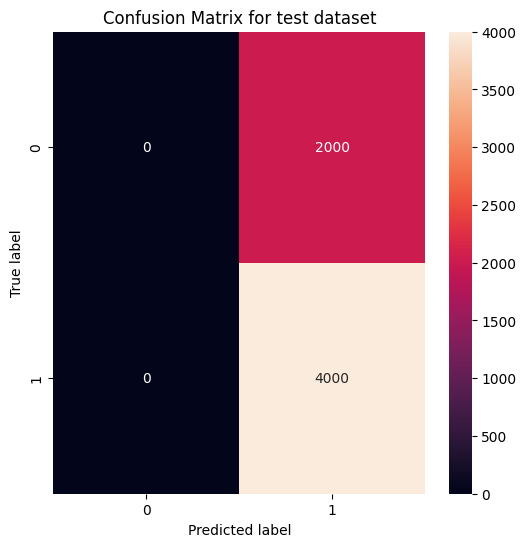

In [656]:
# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix for test dataset')
plt.show()

###### 

# Testing with MLP model task 1

In [657]:
import os
from tensorflow.keras.models import load_model
import joblib

# Define directories
model_dir = os.path.join("..", "..", "Models", "Seat Classification")

# Define file paths
model_path = os.path.join(model_dir, "mlp_model_Seat_Classification.h5")
scaler_path = os.path.join(model_dir, "mlp_scaler_Seat_Classification.pkl")

# Load the trained MLP model
mlp_model = load_model(model_path)

# Optional: compile if you plan to evaluate metrics
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load the scaler
scaler = joblib.load(scaler_path)

print(f"MLP model loaded from: {os.path.abspath(model_path)}")
print(f"Scaler loaded from: {os.path.abspath(scaler_path)}")

# Ensure input is a NumPy array
X_input = test_x_dataset_1_reduced.values if hasattr(test_x_dataset_1_reduced, 'values') else test_x_dataset_1_reduced

# Transform new test data
X_test_scaled = scaler.transform(X_input)

# Predict probabilities
y_pred_prob = mlp_model.predict(X_test_scaled)

# Convert to binary classification (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

y_pred


MLP model loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Seat Classification/mlp_model_Seat_Classification.h5
Scaler loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Seat Classification/mlp_scaler_Seat_Classification.pkl
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


array([1, 1, 1, ..., 1, 1, 1], shape=(6000,))

In [658]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Optional: More detailed report
print("\nClassification Report:")
print(classification_report(test_y, y_pred,zero_division=0))

# Optional: Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred))


Accuracy: 0.6667

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2000
         1.0       0.67      1.00      0.80      4000

    accuracy                           0.67      6000
   macro avg       0.33      0.50      0.40      6000
weighted avg       0.44      0.67      0.53      6000


Confusion Matrix:
[[   0 2000]
 [   0 4000]]


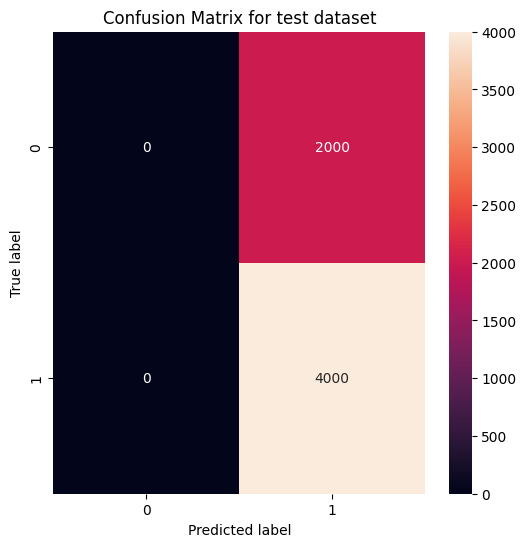

In [659]:
# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix for test dataset')
plt.show()